# Project Histology Tissue Classification Project

In [110]:
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools

In [41]:
tf.__version__

'1.12.0'

In [3]:
def pandas_display():
    """
    Function to setup pandas parameters for interactive session for better display of the DataFrame.

    Returns
    -------
    None
    """

    options = {
        'display': {
            'max_columns': 550,
            'width': 3000,
            'max_colwidth': -1,
            'expand_frame_repr': False,  # Don't wrap to multiple pages
            'max_rows': 200,
            'max_seq_items': 50,         # Max length of printed sequence
            'precision': 4,
            'show_dimensions': False
        },
        'mode': {
            'chained_assignment': None   # Controls SettingWithCopyWarning
        }
    }

    for category, option in options.items():
        for op, value in option.items():
            print('{}.{}'.format(category, op), value)
            pd.set_option('{}.{}'.format(category, op), value)

In [4]:
pandas_display()

display.max_columns 550
display.width 3000
display.max_colwidth -1
display.expand_frame_repr False
display.max_rows 200
display.max_seq_items 50
display.precision 4
display.show_dimensions False
mode.chained_assignment None


## Data exploration

### Data extraction

In [ ]:
base_dir = 'data/kather_texture_2016_image_tiles_5000'

In [ ]:
df = pd.DataFrame({'path': glob(os.path.join(base_dir, '*', '*.tif'))})

In [ ]:
df['file_id'] = df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
df['cell_type'] = df['path'].map(lambda x: os.path.basename(os.path.dirname(x))) 
df['cell_type_idx'] = df['cell_type'].map(lambda x: int(x.split('_')[0]))
df['cell_type'] = df['cell_type'].map(lambda x: x.split('_')[1])
df['full_image_name'] = df['file_id'].map(lambda x: x.split('_Row')[0])
df['full_image_row'] = df['file_id'].map(lambda x: int(x.split('_')[-3]))
df['full_image_col'] = df['file_id'].map(lambda x: int(x.split('_')[-1]))

In [ ]:
df['image'] = df['path'].map(imread)

In [ ]:
df.to_pickle('./data/dataframe_Kather_texture_2016_image_tiles_5000.pkl')

reading data from the pkl file

In [9]:
pd.__version__

'0.23.4'

In [256]:
df=pd.read_pickle('./data/dataframe_Kather_texture_2016_image_tiles_5000.pkl')

In [ ]:
#df.describe(exclude=[np.number])

In [8]:
df.head()

path                                         file_id cell_type  cell_type_idx                full_image_name  full_image_row  full_image_col                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [10]:
df.sample(3)

path                                       file_id cell_type  cell_type_idx               full_image_name  full_image_row  full_image_col                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [11]:
df.dtypes

path               object
file_id            object
cell_type          object
cell_type_idx      int64 
full_image_name    object
full_image_row     int64 
full_image_col     int64 
image              object
dtype: object

In [12]:
df.isnull().sum()

path               0
file_id            0
cell_type          0
cell_type_idx      0
full_image_name    0
full_image_row     0
full_image_col     0
image              0
dtype: int64

In [13]:
df['cell_type'].unique()

array(['STROMA', 'MUCOSA', 'DEBRIS', 'TUMOR', 'COMPLEX', 'EMPTY',
       'LYMPHO', 'ADIPOSE'], dtype=object)

In [14]:
df.memory_usage(deep=True).sum()/1024**2

2.6891908645629883

In [15]:
 df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
path               5000 non-null object
file_id            5000 non-null object
cell_type          5000 non-null object
cell_type_idx      5000 non-null int64
full_image_name    5000 non-null object
full_image_row     5000 non-null int64
full_image_col     5000 non-null int64
image              5000 non-null object
dtypes: int64(3), object(5)
memory usage: 2.7 MB


In [16]:
len(df), len(df.columns)

(5000, 8)

In [17]:
df.shape

(5000, 8)

In [6]:
df['cell_type'].value_counts()

EMPTY      625
ADIPOSE    625
TUMOR      625
COMPLEX    625
LYMPHO     625
MUCOSA     625
DEBRIS     625
STROMA     625
Name: cell_type, dtype: int64

In [18]:
df['full_image_name'][df['full_image_name'].duplicated()]

3542    140E1_CRC-Prim-HE-06_005.tif
3665    1411C_CRC-Prim-HE-06_005.tif
3742    14AD7_CRC-Prim-HE-06_005.tif
4229    15EA0_CRC-Prim-HE-01_013.tif
4972    16193_CRC-Prim-HE-05_032.tif
Name: full_image_name, dtype: object

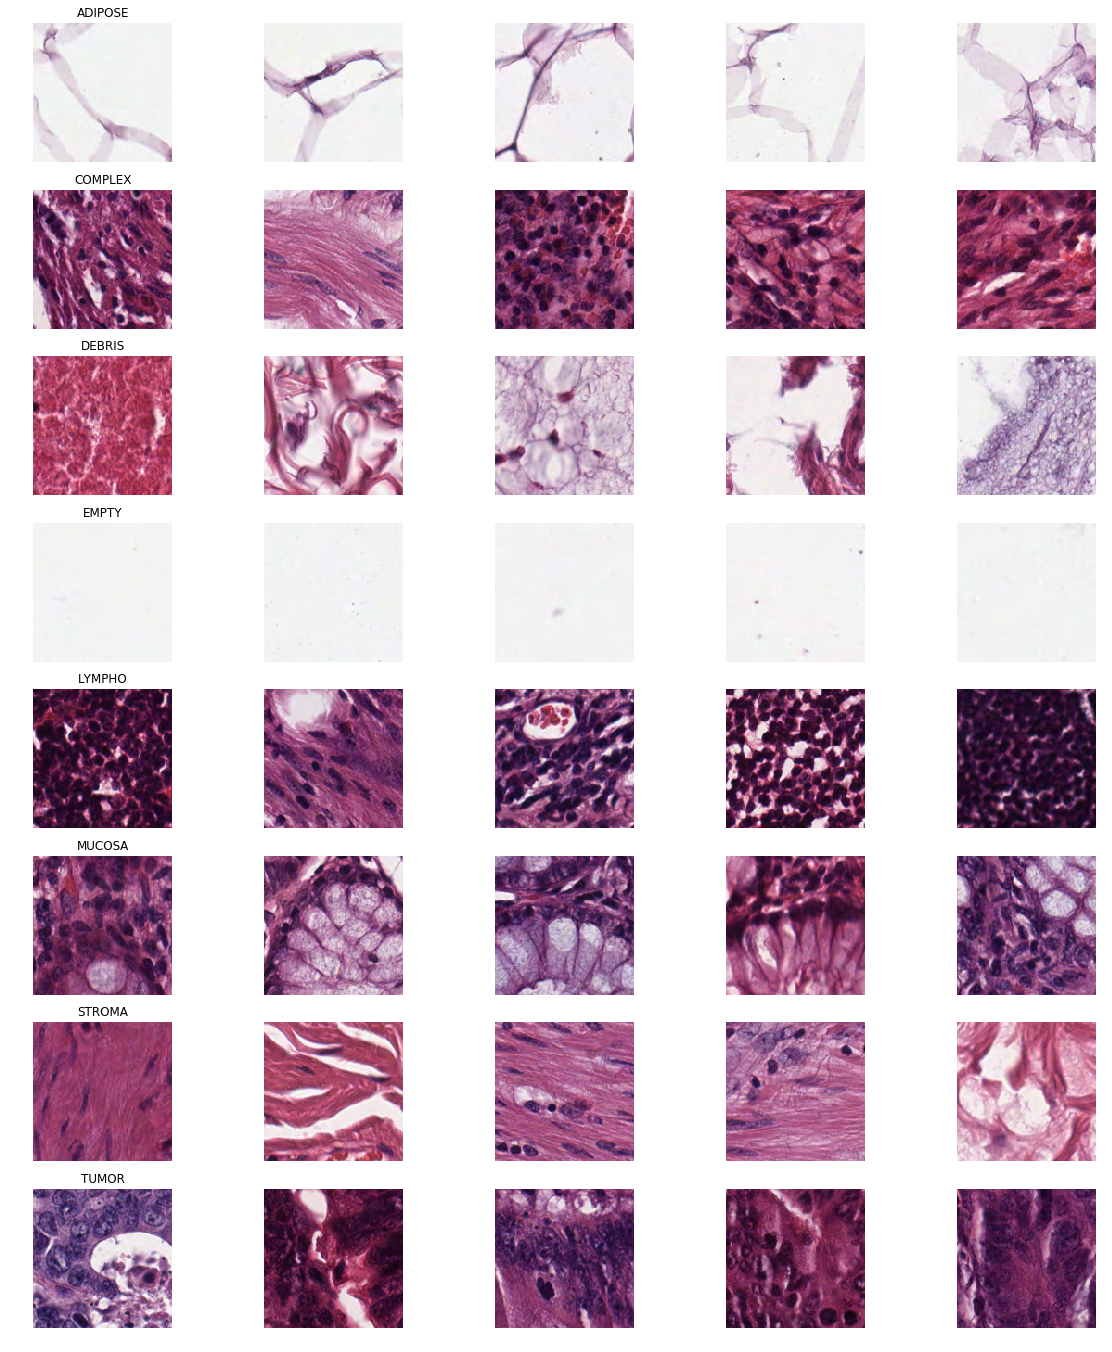

In [19]:
n_samples = 5
fig, m_axs = plt.subplots(8, n_samples, figsize = (4*n_samples, 3*8))

for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

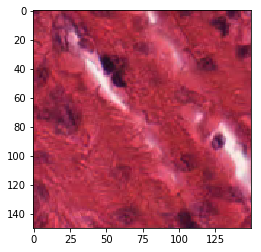

In [20]:
plt.imshow(df['image'][0]);

In [21]:
df['image'][0].shape

(150, 150, 3)

In [22]:
df['image'][0].dtype

dtype('uint8')

### Distribution of the data

In [258]:
df[['path', 'file_id', 'cell_type', 'cell_type_idx', 'full_image_name', 'full_image_row', 'full_image_col']].head(5)

,path,file_id,cell_type,cell_type_idx,full_image_name,full_image_row,full_image_col
0,data/kather_texture_2016_image_tiles_5000/02_STROMA/14389_CRC-Prim-HE-07_026.tif_Row_751_Col_151.tif,14389_CRC-Prim-HE-07_026.tif_Row_751_Col_151,STROMA,2,14389_CRC-Prim-HE-07_026.tif,751,151
1,data/kather_texture_2016_image_tiles_5000/02_STROMA/1163A_CRC-Prim-HE-05_009b.tif_Row_751_Col_1201.tif,1163A_CRC-Prim-HE-05_009b.tif_Row_751_Col_1201,STROMA,2,1163A_CRC-Prim-HE-05_009b.tif,751,1201
2,data/kather_texture_2016_image_tiles_5000/02_STROMA/118E_CRC-Prim-HE-02_015.tif_Row_301_Col_3601.tif,118E_CRC-Prim-HE-02_015.tif_Row_301_Col_3601,STROMA,2,118E_CRC-Prim-HE-02_015.tif,301,3601
3,data/kather_texture_2016_image_tiles_5000/02_STROMA/12238_CRC-Prim-HE-09.tif_Row_151_Col_2551.tif,12238_CRC-Prim-HE-09.tif_Row_151_Col_2551,STROMA,2,12238_CRC-Prim-HE-09.tif,151,2551
4,data/kather_texture_2016_image_tiles_5000/02_STROMA/100A6_CRC-Prim-HE-02_029.tif_Row_601_Col_301.tif,100A6_CRC-Prim-HE-02_029.tif_Row_601_Col_301,STROMA,2,100A6_CRC-Prim-HE-02_029.tif,601,301


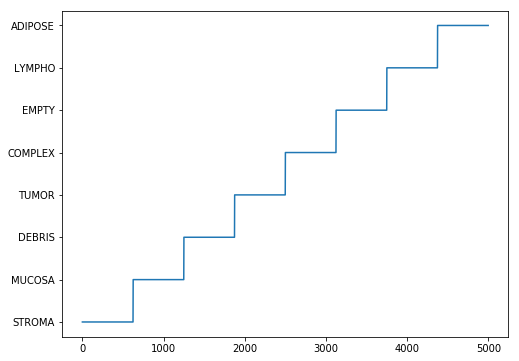

In [259]:
plt.figure(figsize=(8,6))
plt.plot(df.index.values, df['cell_type'])
plt.show()

In [260]:
max(df.index.values), min(df.index.values)

(4999, 0)

In [261]:
import random
rows = df.index.values
random.shuffle(rows)
rows

array([2099, 2344, 2698, ..., 3681,  868, 1692])

In [262]:
max(rows), min(rows)

(4999, 0)

In [263]:
sum(df.index.values)

12497500

In [264]:
sum(rows)

12497500

In [268]:
df=df.reindex(rows)
df.sort_index(inplace=True)

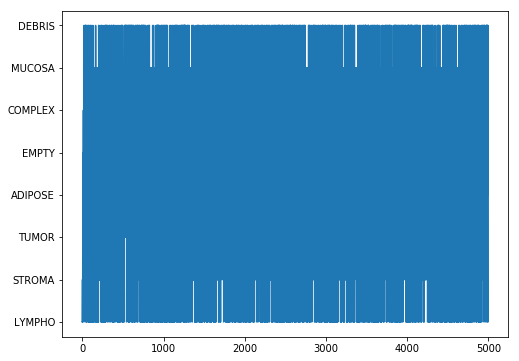

In [269]:
plt.figure(figsize=(8,6))
plt.plot(df.index.values, df['cell_type'])
plt.show()

In [270]:
df['cell_type']

0       LYMPHO 
1       LYMPHO 
2       STROMA 
3       LYMPHO 
4       STROMA 
5       TUMOR  
6       LYMPHO 
7       ADIPOSE
8       EMPTY  
9       STROMA 
10      TUMOR  
11      STROMA 
12      COMPLEX
13      COMPLEX
14      STROMA 
15      STROMA 
16      EMPTY  
17      MUCOSA 
18      TUMOR  
19      TUMOR  
20      DEBRIS 
21      TUMOR  
22      EMPTY  
23      COMPLEX
24      MUCOSA 
25      ADIPOSE
26      ADIPOSE
27      MUCOSA 
28      MUCOSA 
29      STROMA 
30      ADIPOSE
31      ADIPOSE
32      EMPTY  
33      DEBRIS 
34      LYMPHO 
35      TUMOR  
36      MUCOSA 
37      DEBRIS 
38      COMPLEX
39      EMPTY  
40      DEBRIS 
41      TUMOR  
42      STROMA 
43      DEBRIS 
44      EMPTY  
45      ADIPOSE
46      EMPTY  
47      COMPLEX
48      MUCOSA 
49      COMPLEX
50      TUMOR  
51      LYMPHO 
52      COMPLEX
53      DEBRIS 
54      COMPLEX
55      LYMPHO 
56      TUMOR  
57      COMPLEX
58      EMPTY  
59      MUCOSA 
60      MUCOSA 
61      TUMOR  
62      

### labels+hotencoding

In [276]:
df_label = pd.get_dummies(df['cell_type'])

In [277]:
df_label.head()

,ADIPOSE,COMPLEX,DEBRIS,EMPTY,LYMPHO,MUCOSA,STROMA,TUMOR
0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0
3,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0


In [278]:
dict_label=list(df_label.columns)
dict_label

['ADIPOSE',
 'COMPLEX',
 'DEBRIS',
 'EMPTY',
 'LYMPHO',
 'MUCOSA',
 'STROMA',
 'TUMOR']

In [279]:
label=df_label.values

In [280]:
label.shape, label.dtype

((5000, 8), dtype('uint8'))

In [281]:
label

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=uint8)

### features

In [282]:
data=np.array(df['image'].tolist())

In [283]:
data.shape, data.dtype

((5000, 150, 150, 3), dtype('uint8'))

### Split training, testing and validation set

In [284]:
x, x_test, y, y_test = train_test_split(data, label, test_size=0.2,train_size=0.8)
x_train, x_eval, y_train, y_eval = train_test_split(x,y,test_size = 0.25,train_size =0.75)

In [285]:
print('train set:', x_train.shape, y_train.shape)
print('test set :', x_test.shape, y_test.shape)
print('eval set :', x_eval.shape, y_eval.shape)

train set: (3000, 150, 150, 3) (3000, 8)
test set : (1000, 150, 150, 3) (1000, 8)
eval set : (1000, 150, 150, 3) (1000, 8)


In [286]:
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
x_eval = np.array( x_eval, dtype=np.float32)

In [287]:
np.amax(x_train), np.amax(x_test), np.amax(x_eval)

(255.0, 255.0, 255.0)

In [288]:
np.amin(x_train), np.amin(x_test), np.amin(x_eval)

(0.0, 0.0, 0.0)

In [289]:
x_train /= 255
x_test /= 255
x_eval /= 255

In [290]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('x_eval shape:', x_eval.shape)

x_train shape: (3000, 150, 150, 3)
x_test shape: (1000, 150, 150, 3)
x_eval shape: (1000, 150, 150, 3)


### CNN models

In [291]:
input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])

In [292]:
input_shape

(150, 150, 3)

### Model 1

In [364]:
# Must define the input shape in the first layer of the neural network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, 3, 3, input_shape=input_shape))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

#model.add(tf.keras.layers.Conv2D(32, 3, 3))
#model.add(tf.keras.layers.Activation('relu'))
#model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, 3, 3))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Activation('sigmoid'))

In [365]:
# Take a look at the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
activation_37 (Activation)   (None, 50, 50, 32)        0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
activation_38 (Activation)   (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1024)              0         
__________

### Model 2

Test loss: 0.7066132221221924
Test accuracy: 0.774
10 epochs
batch size 64

Test loss: 0.6791752157211304
Test accuracy: 0.741
10 epochs
batch size 128

In [366]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (5,5),padding = 'same',activation ='relu', input_shape = input_shape))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256,activation = "relu"))          
model.add(tf.keras.layers.Dense(64,activation = "relu"))
model.add(tf.keras.layers.Dense(32,activation = "relu"))

model.add(tf.keras.layers.Dense(8, activation = "softmax"))

In [367]:
# Take a look at the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 150, 150, 128)     9728      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 75, 75, 128)       0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 75, 75, 128)       0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 75, 75, 64)        73792     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 37, 37, 64)        36928     
__________

### Model 3

In [393]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = input_shape))
model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.MaxPooling2D(pool_size = 3)) 

model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.MaxPooling2D(pool_size = 3)) 

model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.MaxPooling2D(pool_size = 3))

model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.MaxPooling2D(pool_size = 3))
model.add(tf.keras.layers.GlobalMaxPooling2D())
model.add(tf.keras.layers.Dense(8, activation = 'softmax'))

In [394]:
# Take a look at the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
dropout_18 (Dropout)         (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 50, 50, 32)        4640      
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 50, 50, 32)        9248      
__________

### Model 4

In [422]:
#Load the VGG model
vgg_conv = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = input_shape)

In [423]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x45f93a550> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x45f93a240> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x45f962ac8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x456374a20> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x45f962550> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x45e1b47b8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x45e1ceeb8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x45fb8d9e8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x45fbacc18> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x2000f5710> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x200129dd8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x200108f98> False
<tensorflow.py

In [424]:
# Create the model
model = tf.keras.models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(8, activation='softmax'))

In [425]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [426]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)

In [427]:
EPOCHS=10
#BATCH_SIZE=256
BATCH_SIZE=128
#BATCH_SIZE=64

In [428]:
history=model.fit(x_train,
                  y_train,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=(x_test, y_test),
                  callbacks=[checkpointer])

Train on 3000 samples, validate on 1000 samples
Epoch 1/10
2944/3000 [============================>.] - ETA: 12s - loss: 1.9755 - acc: 0.2755
Epoch 00001: val_loss improved from inf to 1.68525, saving model to model.weights.best.hdf5
3000/3000 [==============================] - 878s 293ms/step - loss: 1.9679 - acc: 0.2767 - val_loss: 1.6853 - val_acc: 0.3040
Epoch 2/10
2944/3000 [============================>.] - ETA: 12s - loss: 1.4988 - acc: 0.3577
Epoch 00002: val_loss improved from 1.68525 to 1.50649, saving model to model.weights.best.hdf5
3000/3000 [==============================] - 882s 294ms/step - loss: 1.4948 - acc: 0.3590 - val_loss: 1.5065 - val_acc: 0.3970
Epoch 3/10
2944/3000 [============================>.] - ETA: 12s - loss: 1.3013 - acc: 0.4606
Epoch 00003: val_loss improved from 1.50649 to 1.07579, saving model to model.weights.best.hdf5
3000/3000 [==============================] - 876s 292ms/step - loss: 1.2987 - acc: 0.4603 - val_loss: 1.0758 - val_acc: 0.5680
Epoch

In [429]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


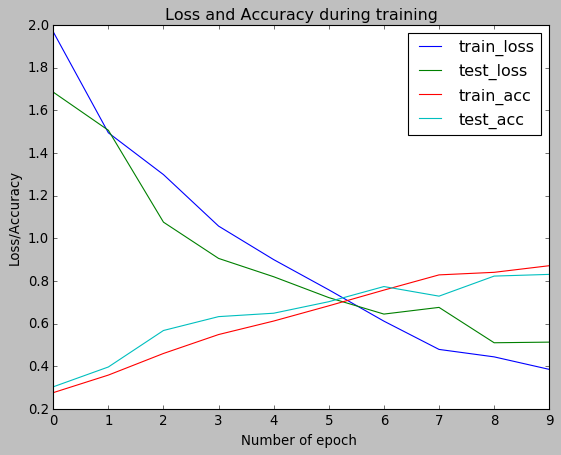

In [430]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("classic")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="test_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="test_acc")
plt.title("Loss and Accuracy during training")
plt.xlabel("Number of epoch ")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best");

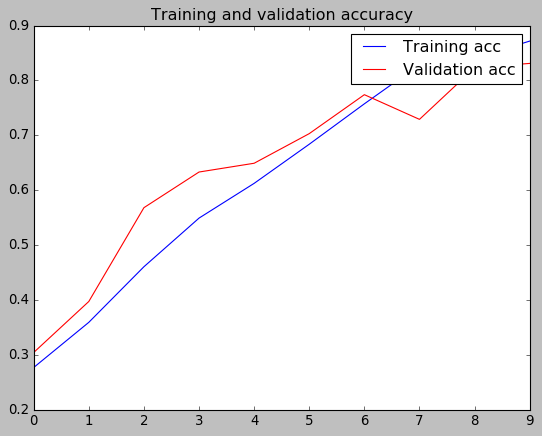

In [431]:
plt.plot(np.arange(0, EPOCHS), history.history['acc'], 'b', label='Training acc')
plt.plot(np.arange(0, EPOCHS), history.history['val_acc'], 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend();

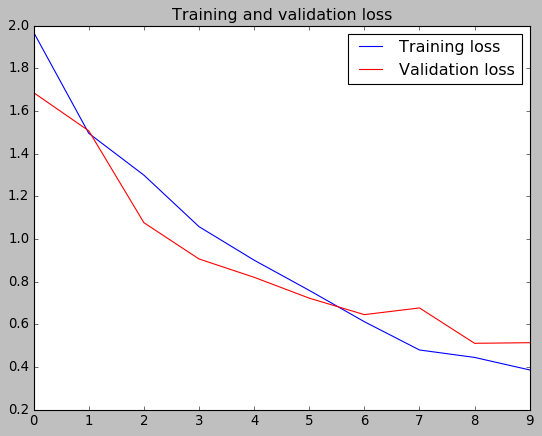

In [432]:
plt.plot(np.arange(0, EPOCHS), history.history['loss'], 'b', label='Training loss')
plt.plot(np.arange(0, EPOCHS), history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend();

In [433]:
score = model.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5134660834074021
Test accuracy: 0.831


In [436]:
score = model.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.26766909344991047
Train accuracy: 0.9070000001589458


## Load Model with the best validation accuracy

In [437]:
# Load the weights with the best validation accuracy
model.load_weights('model.weights.best.hdf5')
# Load the weights with the best validation accuracy
model.load_weights('model.weights.best.hdf5')

In [438]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)

# Print test accuracy
print('Test accuracy:', score[1])

Test accuracy: 0.823


## Visualize prediction

In [439]:
y_hat = model.predict(x_test)

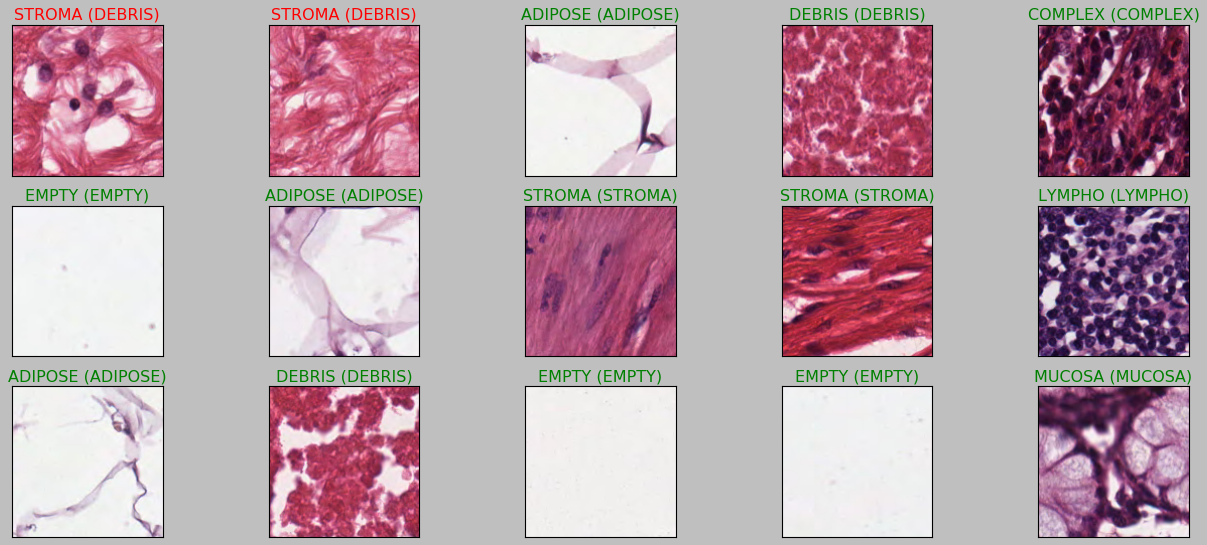

In [440]:
# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(dict_label[predict_index], 
                                  dict_label[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

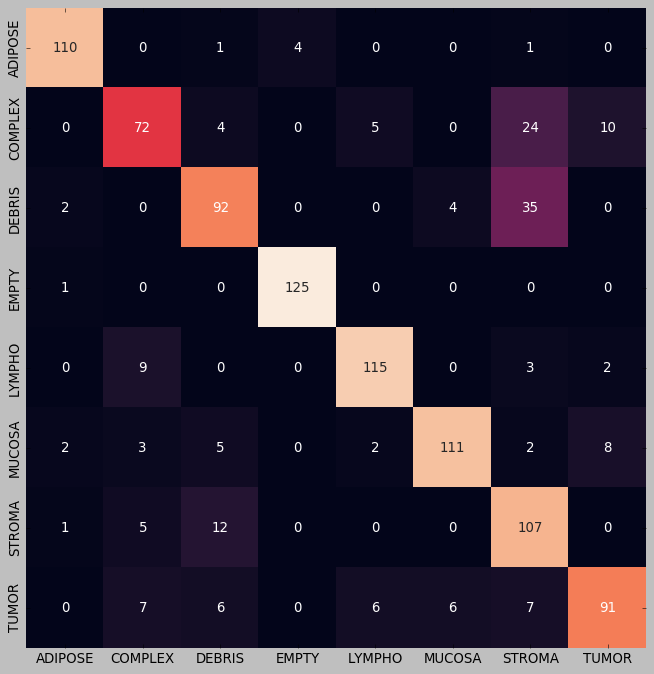

In [441]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
predict_index = np.argmax(y_hat, axis = 1)
true_index = np.argmax(y_test, axis = 1)
sns.heatmap(confusion_matrix(true_index, predict_index), 
            annot=True, cbar=False, fmt='d', ax=ax)
ax.set_yticklabels(dict_label, minor=False)
ax.set_xticklabels(dict_label, minor=False);

In [442]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label');
    plt.xlabel('Predicted label');

In [443]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(true_index, predict_index)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[110   0   1   4   0   0   1   0]
 [  0  72   4   0   5   0  24  10]
 [  2   0  92   0   0   4  35   0]
 [  1   0   0 125   0   0   0   0]
 [  0   9   0   0 115   0   3   2]
 [  2   3   5   0   2 111   2   8]
 [  1   5  12   0   0   0 107   0]
 [  0   7   6   0   6   6   7  91]]


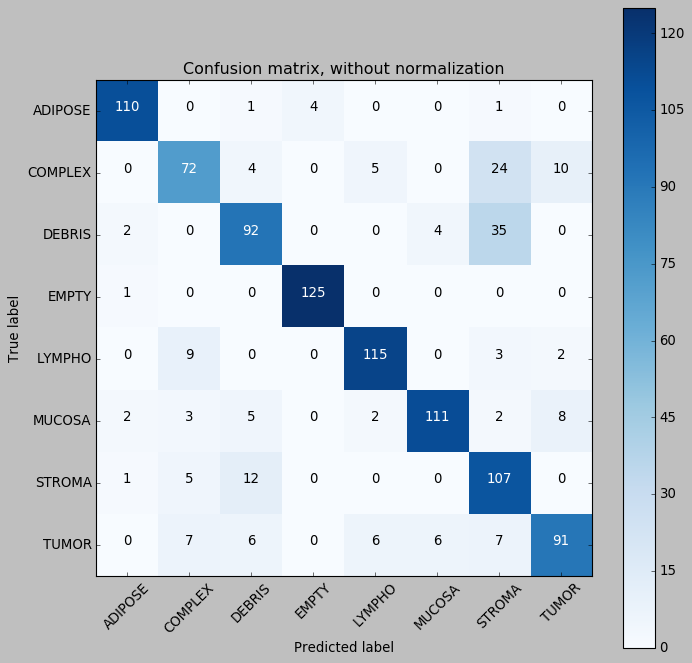

In [444]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=dict_label,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.95 0.   0.01 0.03 0.   0.   0.01 0.  ]
 [0.   0.63 0.03 0.   0.04 0.   0.21 0.09]
 [0.02 0.   0.69 0.   0.   0.03 0.26 0.  ]
 [0.01 0.   0.   0.99 0.   0.   0.   0.  ]
 [0.   0.07 0.   0.   0.89 0.   0.02 0.02]
 [0.02 0.02 0.04 0.   0.02 0.83 0.02 0.06]
 [0.01 0.04 0.1  0.   0.   0.   0.86 0.  ]
 [0.   0.06 0.05 0.   0.05 0.05 0.06 0.74]]


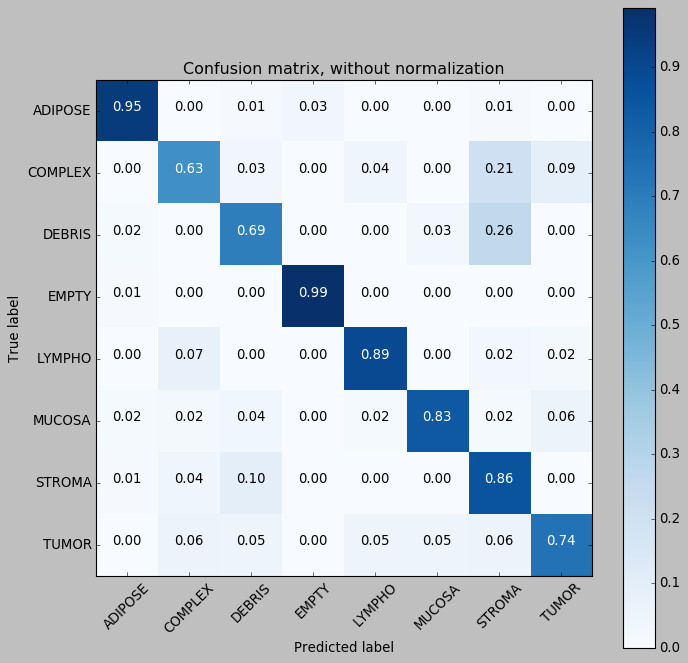

In [445]:
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=dict_label,normalize=True,
                      title='Confusion matrix, without normalization')